# Set Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# change to your working directory
#%cd "/content/drive/MyDrive/shared folder/Master_Thesis"
%cd "/content/drive/MyDrive/shared_folder/Master_Thesis" 

/content/drive/.shortcut-targets-by-id/1lHcON5EHJDerZlJ2mPUGsY4w6iFLBKs5/shared_folder/Master_Thesis


In [ ]:
!pip install adapt

In [ ]:
import os, random, shutil, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image

from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, GaussianNoise 
from tensorflow.keras.layers import BatchNormalization,  GlobalMaxPooling2D, GlobalAveragePooling2D,  Add
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, ResNet50V2, MobileNetV3Large
from tensorflow.keras.constraints import MinMaxNorm, MaxNorm
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

from adapt.parameter_based import FineTuning
from adapt.feature_based import MDD
from adapt.utils import UpdateLambda

In [ ]:
print("GPU Available: ", tf.test.is_gpu_available())
print(tf.__version__)

GPU Available:  True
2.8.0


In [ ]:
# Original Dataset
Source_dir_train1 = "./Images/DANN/Source/LC25000_mix_data_256_3200_train1.pkl"
Source_dir_train2 = "./Images/DANN/Source/LC25000_mix_data_256_3200_train2.pkl"
Source_dir_train3 = "./Images/DANN/Source/LC25000_mix_data_256_3200_train3.pkl"


Target_dir_train1 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_train1.pkl")
Target_dir_train2 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_train2.pkl")
Target_dir_test1 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_test1.pkl")
Target_dir_test2 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_test2.pkl")

# Cyclegan Dataset

Target_cyclegan_dir_train1 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_train1.pkl")
Target_cyclegan_dir_train2 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_train2.pkl")
Target_cyclegan_dir_test1 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_test1.pkl")
Target_cyclegan_dir_test2 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_test2.pkl")

In [ ]:
BATCH_SIZE = 8
CHANNELS = 3
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

# Loading Dataset

## configuration

In [ ]:
#rescale
def convert(data_list):
    for i in range(len(data_list)): data_list[i]=data_list[i]/255

In [ ]:
# Data Augmentation
def augment(image):
    image = np.array(image, dtype=np.float32)
    #image = (image / 255.0)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.15, seed=1)
    image = tf.image.random_hue(image, max_delta=0.09, seed=1)
    return image

def augment_1(image):
    image = np.array(image, dtype=np.float32)
    image = (image / 255.0)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.15, seed=1)
    image = tf.image.random_hue(image, max_delta=0.09, seed=1)
    return image

# process dataset
def data_augmentation(dataset):
    au=[]
    for file in dataset:
        file_au = augment(file)
        au.append(file_au)
    return au

## LC25000 Data Augmentation Dataset

In [ ]:
# LC25000 Dataset
with open(os.path.abspath(Source_dir_train1), "rb") as f:
    LC25000_train1 = pickle.load(f)
with open(os.path.abspath(Source_dir_train2), "rb") as f:
    LC25000_train2 = pickle.load(f)
with open(os.path.abspath(Source_dir_train3), "rb") as f:
    LC25000_train3 = pickle.load(f)

In [ ]:
LC25000_train_data = LC25000_train1['train'] + LC25000_train2['train'] + LC25000_train3['train'] 
LC25000_train_labels = np.concatenate((LC25000_train1['train_label'],LC25000_train2['train_label'],LC25000_train3['train_label']))

In [ ]:
LC25000_train_lab = tf.one_hot(LC25000_train_labels, depth=3)

### Data Augmentation Process

In [ ]:
LC25000_train_data_au = data_augmentation(LC25000_train_data)

In [ ]:
LC25000_train_data_au = np.array(LC25000_train_data_au, dtype=np.float32)

In [ ]:
print("The shape of LC25000_train_data: ", LC25000_train_data_au.shape)
print("The shape of LC25000_train_labels: ", LC25000_train_labels.shape)

The shape of LC25000_train_data:  (3200, 256, 256, 3)
The shape of LC25000_train_labels:  (3200,)


In [ ]:
import gc
gc.collect()

19268

## TCGA Cyclegan Dataset

In [ ]:
# TCGA Dataset
with open(os.path.abspath(Target_cyclegan_dir_train1), "rb") as f:
    TCGA_cyclegan_train1 = pickle.load(f)
with open(os.path.abspath(Target_cyclegan_dir_train2), "rb") as f:
    TCGA_cyclegan_train2 = pickle.load(f)
with open(os.path.abspath(Target_cyclegan_dir_test1), "rb") as f:
    TCGA_cyclegan_test1 = pickle.load(f)
with open(os.path.abspath(Target_cyclegan_dir_test2), "rb") as f:
    TCGA_cyclegan_test2 = pickle.load(f)

In [ ]:
TCGA_cyclegan_train_data = TCGA_cyclegan_train1['train'] + TCGA_cyclegan_train2['train']
TCGA_cyclegan_train_labels = np.concatenate((TCGA_cyclegan_train1['train_label'],TCGA_cyclegan_train2['train_label']))
TCGA_cyclegan_test_data = TCGA_cyclegan_test1['test'] + TCGA_cyclegan_test2['test']
TCGA_cyclegan_test_labels = np.concatenate((TCGA_cyclegan_test1['test_label'],TCGA_cyclegan_test2['test_label']))

In [ ]:
TCGA_cyclegan_train_lab = tf.one_hot(TCGA_cyclegan_train_labels, depth=3)
TCGA_cyclegan_test_lab = tf.one_hot(TCGA_cyclegan_test_labels, depth=3)

In [ ]:
TCGA_cyclegan_train_data = np.array(TCGA_cyclegan_train_data, dtype=np.float32)
TCGA_cyclegan_test_data = np.array(TCGA_cyclegan_test_data, dtype=np.float32)

In [ ]:
print("The shape of TCGA_cyclegan_train_data: ", TCGA_cyclegan_train_data.shape)
print("The shape of TCGA_cyclegan_train_labels: ", TCGA_cyclegan_train_labels.shape)
print("The shape of TCGA_cyclegan_test_data: ", TCGA_cyclegan_test_data.shape)
print("The shape of TCGA_cyclegan_test_labels: " , TCGA_cyclegan_test_labels.shape)

The shape of TCGA_cyclegan_train_data:  (3200, 256, 256, 3)
The shape of TCGA_cyclegan_train_labels:  (3200,)
The shape of TCGA_cyclegan_test_data:  (3200, 256, 256, 3)
The shape of TCGA_cyclegan_test_labels:  (3200,)


In [ ]:
import gc
gc.collect()

756

## Datasets Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


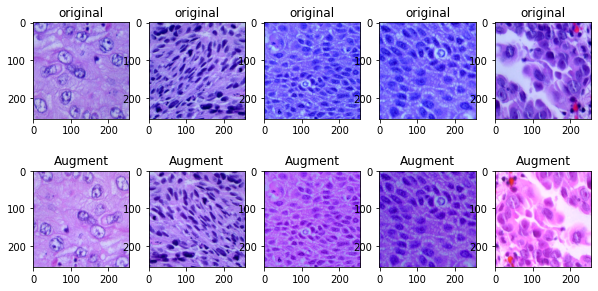

In [ ]:
# show the difference bewteen Original images and Data Augmentation images
fig = plt.figure(figsize=(10, 10))

for i in range(5):
    sample = random.choice(LC25000_train_data)
    fig.add_subplot(2,5,i+1)
    img = array_to_img(sample)
    plt.title("original")
    plt.imshow(img)
    fig.add_subplot(1,5,i+1)
    img1 = augment_1(sample)
    plt.title("Augment")
    plt.imshow(img1)

<function matplotlib.pyplot.show>

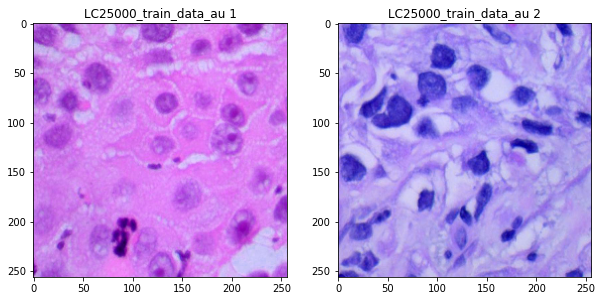

In [ ]:
# random show source images
fig = plt.subplots(1,2,figsize=(10,10))
#plt.suptitle("Source Domain = LC25000", fontsize=18)
ax1=plt.subplot(1,2,1)
sample1 = random.choice(LC25000_train_data_au)
img1 = array_to_img(sample1)
plt.show
plt.title("LC25000_train_data_au 1")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(LC25000_train_data_au)
img2 = array_to_img(sample2)
plt.title("LC25000_train_data_au 2")
plt.imshow(img2)
plt.show

<function matplotlib.pyplot.show>

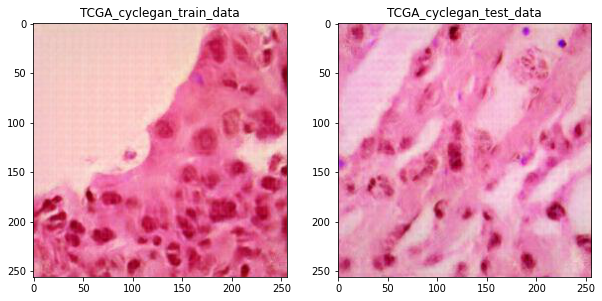

In [ ]:
# random show images
plt.subplots(1,2,figsize=(10,10))
ax1=plt.subplot(1,2,1)
sample1 = random.choice(TCGA_cyclegan_train_data)
img1 = array_to_img(sample1)
plt.title("TCGA_cyclegan_train_data")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(TCGA_cyclegan_test_data)
img2 = array_to_img(sample2)
plt.title("TCGA_cyclegan_test_data")
plt.imshow(img2)
plt.show

# Domain Adaptation

## Build Model

### Feature Extractor - ResNet50V2

In [ ]:
resnet50 = ResNet50(include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS), pooling="avg")

first_layer = resnet50.get_layer('conv5_block2_out')
inputs = Input(first_layer.output_shape[1:])

for layer in resnet50.layers[resnet50.layers.index(first_layer)+1:]:
    if layer.name == "conv5_block3_1_conv":
        x = layer(inputs)
    elif layer.name == "conv5_block3_add":  # change name
        x = layer([inputs, x])
    else:
        if layer.name == "conv5_block3_preact_bn":
            pass
        else:
            x = layer(x)

first_blocks = Model(resnet50.input, first_layer.output)
last_block = Model(inputs, x)

In [ ]:
def load_resnet50(path="./Model/DANN_Model/resnet50_last_block_256.hdf5"):
    model = load_model(path)
    for i in range(len(model.layers)):
        if model.layers[i].__class__.__name__ == "BatchNormalization":
            model.layers[i].trainable = False
    return model

last_block.summary()
last_block.save("./Model/DANN_Model/resnet50_last_block_256.hdf5")

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 8, 8, 2048)  0           []                               
                                ]                                                                 
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 8, 8, 512)    1049088     ['input_4[0][0]']                
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv5_block3_1_conv[1][0]']    
 ization)                                                                                         
                                                                                            

### Extract the features 

In [ ]:
LC25000_train_data_au_ex = first_blocks.predict(preprocess_input(np.stack(LC25000_train_data_au)))

In [ ]:
import gc
gc.collect()

31771

In [ ]:
LC25000_train_data_au_ex = first_blocks.predict(preprocess_input(np.stack(LC25000_train_data_au)))
TCGA_cyclegan_train_data_ex = first_blocks.predict(preprocess_input(np.stack(TCGA_cyclegan_train_data)))
# TCGA_cyclegan_test_data_ex = first_blocks.predict(preprocess_input(np.stack(TCGA_cyclegan_test_data)))

print("LC25000_train_data_au (source) shape: %s"%str(LC25000_train_data_au.shape))
print("TCGA_cyclegan_train_data (target) shape: %s"%str(TCGA_cyclegan_train_data.shape))

LC25000_train_data_au (source) shape: (3200, 256, 256, 3)
TCGA_cyclegan_train_data (target) shape: (3200, 256, 256, 3)


### Label Predictor

In [ ]:
def get_task(dropout=0.5, max_norm=0.5):
    model = Sequential()
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation="softmax",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    return model

In [ ]:
class MyDecay(LearningRateSchedule):

    def __init__(self, max_steps=1000, mu_0=0.01, alpha=10, beta=0.75):
        self.mu_0 = mu_0
        self.alpha = alpha
        self.beta = beta
        self.max_steps = float(max_steps)

    def __call__(self, step):
        p = step / self.max_steps
        return self.mu_0 / (1+self.alpha * p)**self.beta

In [ ]:
import gc
gc.collect()

1402

# Fit without adaptation

### Run 1

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=8, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
400/400 [==============================] - 7s 15ms/step - loss: 0.4269 - acc: 0.8506 - val_loss: 1.3903 - val_acc: 0.4172
Epoch 2/5
400/400 [==============================] - 5s 14ms/step - loss: 0.1429 - acc: 0.9469 - val_loss: 1.7833 - val_acc: 0.4366
Epoch 3/5
400/400 [==============================] - 5s 14ms/step - loss: 0.1037 - acc: 0.9628 - val_loss: 2.0201 - val_acc: 0.4425
Epoch 4/5
400/400 [==============================] - 5s 14ms/step - loss: 0.0979 - acc: 0.9622 - val_loss: 2.4730 - val_acc: 0.4347
Epoch 5/5
400/400 [==============================] - 5s 14ms/step - loss: 0.0966 - acc: 0.9659 - val_loss: 2.3435 - val_acc: 0.4512
Epoch 1/100
400/400 [==============================] - 9s 19ms/step - loss: 0.0886 - acc: 0.9709 - val_loss: 2.4788 - val_acc: 0.4509
Epoch 2/100
400/400 [==============================] - 5s 12ms/step - loss: 0.0775 - acc: 0.9737 - val_loss: 2.6726 - val_acc: 0.4494
Epoch 3/100
400/400 [==============================] - 5s 12ms/step - lo

### Run 2

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=8, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
400/400 [==============================] - 7s 10ms/step - loss: 0.4199 - acc: 0.8581 - val_loss: 1.3034 - val_acc: 0.4359
Epoch 2/5
400/400 [==============================] - 3s 8ms/step - loss: 0.1484 - acc: 0.9441 - val_loss: 1.7110 - val_acc: 0.4466
Epoch 3/5
400/400 [==============================] - 3s 8ms/step - loss: 0.0994 - acc: 0.9600 - val_loss: 1.8845 - val_acc: 0.4544
Epoch 4/5
400/400 [==============================] - 3s 8ms/step - loss: 0.0944 - acc: 0.9675 - val_loss: 2.2559 - val_acc: 0.4384
Epoch 5/5
400/400 [==============================] - 3s 8ms/step - loss: 0.0804 - acc: 0.9681 - val_loss: 2.1782 - val_acc: 0.4569
Epoch 1/100
400/400 [==============================] - 7s 14ms/step - loss: 0.0879 - acc: 0.9706 - val_loss: 2.4962 - val_acc: 0.4403
Epoch 2/100
400/400 [==============================] - 5s 11ms/step - loss: 0.0692 - acc: 0.9781 - val_loss: 2.7279 - val_acc: 0.4431
Epoch 3/100
400/400 [==============================] - 5s 11ms/step - loss: 

### Run 3

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=8, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
400/400 [==============================] - 5s 10ms/step - loss: 0.4367 - acc: 0.8569 - val_loss: 1.3900 - val_acc: 0.4231
Epoch 2/5
400/400 [==============================] - 3s 8ms/step - loss: 0.1372 - acc: 0.9472 - val_loss: 1.8903 - val_acc: 0.4219
Epoch 3/5
400/400 [==============================] - 3s 8ms/step - loss: 0.1048 - acc: 0.9647 - val_loss: 2.3276 - val_acc: 0.4284
Epoch 4/5
400/400 [==============================] - 3s 8ms/step - loss: 0.1053 - acc: 0.9625 - val_loss: 2.3021 - val_acc: 0.4341
Epoch 5/5
400/400 [==============================] - 3s 8ms/step - loss: 0.0761 - acc: 0.9728 - val_loss: 2.2867 - val_acc: 0.4378
Epoch 1/100
400/400 [==============================] - 7s 14ms/step - loss: 0.0813 - acc: 0.9747 - val_loss: 2.6268 - val_acc: 0.4387
Epoch 2/100
400/400 [==============================] - 5s 12ms/step - loss: 0.0821 - acc: 0.9716 - val_loss: 2.7702 - val_acc: 0.4356
Epoch 3/100
400/400 [==============================] - 5s 12ms/step - loss: 

### Run 3

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=8, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
400/400 [==============================] - 5s 11ms/step - loss: 0.4449 - acc: 0.8553 - val_loss: 1.3953 - val_acc: 0.4150
Epoch 2/5
400/400 [==============================] - 3s 9ms/step - loss: 0.1492 - acc: 0.9434 - val_loss: 1.7207 - val_acc: 0.4369
Epoch 3/5
400/400 [==============================] - 3s 9ms/step - loss: 0.1052 - acc: 0.9628 - val_loss: 1.9371 - val_acc: 0.4431
Epoch 4/5
400/400 [==============================] - 3s 9ms/step - loss: 0.0861 - acc: 0.9706 - val_loss: 2.0729 - val_acc: 0.4459
Epoch 5/5
400/400 [==============================] - 3s 9ms/step - loss: 0.0850 - acc: 0.9684 - val_loss: 2.5847 - val_acc: 0.4341
Epoch 1/100
400/400 [==============================] - 7s 14ms/step - loss: 0.0857 - acc: 0.9691 - val_loss: 2.3739 - val_acc: 0.4484
Epoch 2/100
400/400 [==============================] - 5s 12ms/step - loss: 0.0822 - acc: 0.9762 - val_loss: 2.6798 - val_acc: 0.4409
Epoch 3/100
400/400 [==============================] - 5s 12ms/step - loss: 

### Run 5

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=8, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
400/400 [==============================] - 5s 11ms/step - loss: 0.4346 - acc: 0.8509 - val_loss: 1.3998 - val_acc: 0.4422
Epoch 2/5
400/400 [==============================] - 3s 9ms/step - loss: 0.1293 - acc: 0.9516 - val_loss: 1.8125 - val_acc: 0.4403
Epoch 3/5
400/400 [==============================] - 3s 9ms/step - loss: 0.1047 - acc: 0.9634 - val_loss: 2.3704 - val_acc: 0.4219
Epoch 4/5
400/400 [==============================] - 3s 9ms/step - loss: 0.1106 - acc: 0.9594 - val_loss: 2.0135 - val_acc: 0.4506
Epoch 5/5
400/400 [==============================] - 3s 9ms/step - loss: 0.0893 - acc: 0.9684 - val_loss: 2.1806 - val_acc: 0.4466
Epoch 1/100
400/400 [==============================] - 7s 15ms/step - loss: 0.0769 - acc: 0.9703 - val_loss: 2.5285 - val_acc: 0.4478
Epoch 2/100
400/400 [==============================] - 5s 12ms/step - loss: 0.0786 - acc: 0.9731 - val_loss: 2.4953 - val_acc: 0.4387
Epoch 3/100
400/400 [==============================] - 5s 12ms/step - loss: 

### Result

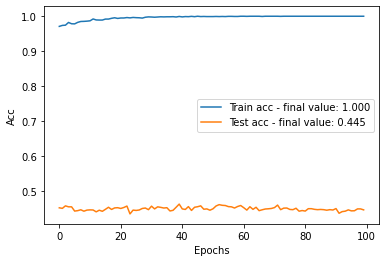

In [ ]:
acc = finetunig.history.history["acc"]; val_acc = finetunig.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


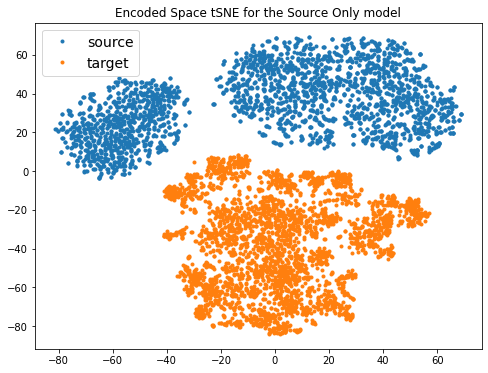

In [ ]:
LC25000_train_data_au_enc = finetunig.transform(LC25000_train_data_au_ex)
TCGA_cyclegan_train_data_enc = finetunig.transform(TCGA_cyclegan_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_au_enc, TCGA_cyclegan_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_au_ex), 0], X_tsne[:len(LC25000_train_data_au_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_au_ex):, 0], X_tsne[len(LC25000_train_data_au_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the Source Only model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(finetunig.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,val_loss,val_acc
count,100.000000,100.000000,100.000000,100.000000
mean,0.011590,0.996359,6.703147,0.448200
std,0.019886,0.006439,1.848964,0.005349
min,0.000003,0.970937,2.441689,0.433437
25%,0.000069,0.995859,5.415374,0.444609
50%,0.001521,0.999375,7.389463,0.447812
75%,0.012875,1.000000,8.161705,0.451953
max,0.088591,1.000000,8.696080,0.461563


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_256/MDD_source_256_Resnet_Adam_0.5e-5_AU_cyclegan.csv")

# Fit with adaptation

### Run 1

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr =  0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd_10 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=3,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_10.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=150, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/150
400/400 [==============================] - 12s 23ms/step - loss: 0.4519 - acc: 0.8487 - disc_loss: 3.4385 - val_loss: 1.4034 - val_acc: 0.4497
Epoch 2/150
400/400 [==============================] - 8s 21ms/step - loss: 0.1195 - acc: 0.9559 - disc_loss: 2.4149 - val_loss: 1.5978 - val_acc: 0.4522
Epoch 3/150
400/400 [==============================] - 8s 21ms/step - loss: 0.1043 - acc: 0.9631 - disc_loss: 1.9364 - val_loss: 1.6375 - val_acc: 0.4419
Epoch 4/150
400/400 [==============================] - 8s 21ms/step - loss: 0.0905 - acc: 0.9672 - disc_loss: 1.6887 - val_loss: 1.8607 - val_acc: 0.4419
Epoch 5/150
400/400 [==============================] - 8s 21ms/step - loss: 0.0926 - acc: 0.9644 - disc_loss: 1.5282 - val_loss: 1.8361 - val_acc: 0.4306
Epoch 6/150
400/400 [==============================] - 8s 21ms/step - loss: 0.0872 - acc: 0.9672 - disc_loss: 1.5636 - val_loss: 2.3160 - val_acc: 0.4769
Epoch 7/150
400/400 [==============================] - 8s 21ms/step - loss:

### Run 2

In [ ]:
lr =  0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd_10 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=3,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_10.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=150, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/150
400/400 [==============================] - 12s 23ms/step - loss: 0.0477 - acc: 0.9934 - disc_loss: 16.9571 - val_loss: 105.9066 - val_acc: 0.4994
Epoch 2/150
400/400 [==============================] - 8s 21ms/step - loss: 0.1009 - acc: 0.9856 - disc_loss: 37.0033 - val_loss: 79.0513 - val_acc: 0.5000
Epoch 3/150
400/400 [==============================] - 8s 21ms/step - loss: 0.0269 - acc: 0.9937 - disc_loss: 42.5767 - val_loss: 79.3074 - val_acc: 0.4994
Epoch 4/150
400/400 [==============================] - 8s 21ms/step - loss: 0.0077 - acc: 0.9972 - disc_loss: 42.8596 - val_loss: 85.3970 - val_acc: 0.4997
Epoch 5/150
400/400 [==============================] - 8s 21ms/step - loss: 0.0063 - acc: 0.9975 - disc_loss: 42.8734 - val_loss: 89.1596 - val_acc: 0.4994
Epoch 6/150
400/400 [==============================] - 8s 21ms/step - loss: 0.0100 - acc: 0.9975 - disc_loss: 42.6938 - val_loss: 86.6965 - val_acc: 0.5000
Epoch 7/150
400/400 [==============================] - 8s 21ms

### Run 3

In [ ]:
lr =  0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
gc.collect()

1250

In [ ]:
mdd_10 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=3,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_10.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=150, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/150
400/400 [==============================] - 12s 23ms/step - loss: 0.0891 - acc: 0.9878 - disc_loss: 24.4274 - val_loss: 137.7697 - val_acc: 0.5000
Epoch 2/150
400/400 [==============================] - 8s 21ms/step - loss: 0.0316 - acc: 0.9941 - disc_loss: 42.2818 - val_loss: 120.1037 - val_acc: 0.5000
Epoch 3/150
400/400 [==============================] - 8s 21ms/step - loss: 0.0334 - acc: 0.9944 - disc_loss: 43.0585 - val_loss: 118.3876 - val_acc: 0.5000
Epoch 4/150
400/400 [==============================] - 8s 21ms/step - loss: 0.0643 - acc: 0.9903 - disc_loss: 42.9981 - val_loss: 99.7393 - val_acc: 0.4994
Epoch 5/150
400/400 [==============================] - 8s 21ms/step - loss: 0.0276 - acc: 0.9953 - disc_loss: 42.8585 - val_loss: 100.7186 - val_acc: 0.5000
Epoch 6/150
400/400 [==============================] - 8s 21ms/step - loss: 0.0248 - acc: 0.9937 - disc_loss: 42.6841 - val_loss: 95.1872 - val_acc: 0.4997
Epoch 7/150
400/400 [==============================] - 8s 2

### Run 3

In [ ]:
lr =  0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd_10 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=3,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_10.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=150, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/150
400/400 [==============================] - 12s 23ms/step - loss: 0.1061 - acc: 0.9769 - disc_loss: 15.3501 - val_loss: 28.3739 - val_acc: 0.4916
Epoch 2/150
400/400 [==============================] - 8s 21ms/step - loss: 0.1847 - acc: 0.9588 - disc_loss: 27.8291 - val_loss: 33.3207 - val_acc: 0.4984
Epoch 3/150
400/400 [==============================] - 8s 21ms/step - loss: 0.3179 - acc: 0.9109 - disc_loss: 40.5609 - val_loss: 36.6062 - val_acc: 0.5000
Epoch 4/150
400/400 [==============================] - 8s 21ms/step - loss: 0.2477 - acc: 0.9337 - disc_loss: 42.7757 - val_loss: 45.7557 - val_acc: 0.5000
Epoch 5/150
400/400 [==============================] - 8s 21ms/step - loss: 0.2195 - acc: 0.9459 - disc_loss: 43.7017 - val_loss: 42.9648 - val_acc: 0.4997
Epoch 6/150
400/400 [==============================] - 9s 22ms/step - loss: 0.2342 - acc: 0.9525 - disc_loss: 44.6186 - val_loss: 41.7367 - val_acc: 0.5019
Epoch 7/150
400/400 [==============================] - 8s 21ms/

### Run 5

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr =  0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
gc.collect()

712

In [ ]:
mdd_10 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=3,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_10.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=150, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/150
400/400 [==============================] - 12s 23ms/step - loss: 0.0632 - acc: 0.9916 - disc_loss: 22.7211 - val_loss: 82.5445 - val_acc: 0.5000
Epoch 2/150
400/400 [==============================] - 8s 21ms/step - loss: 0.0628 - acc: 0.9909 - disc_loss: 42.0606 - val_loss: 77.6102 - val_acc: 0.4984
Epoch 3/150
400/400 [==============================] - 8s 21ms/step - loss: 0.0213 - acc: 0.9947 - disc_loss: 42.8419 - val_loss: 83.4267 - val_acc: 0.4997
Epoch 4/150
400/400 [==============================] - 8s 21ms/step - loss: 0.0314 - acc: 0.9953 - disc_loss: 43.1641 - val_loss: 76.1763 - val_acc: 0.4988
Epoch 5/150
400/400 [==============================] - 8s 21ms/step - loss: 0.0231 - acc: 0.9959 - disc_loss: 42.5788 - val_loss: 76.4209 - val_acc: 0.4984
Epoch 6/150
400/400 [==============================] - 8s 21ms/step - loss: 0.0215 - acc: 0.9953 - disc_loss: 42.4278 - val_loss: 81.7122 - val_acc: 0.5000
Epoch 7/150
400/400 [==============================] - 8s 21ms/

### Result

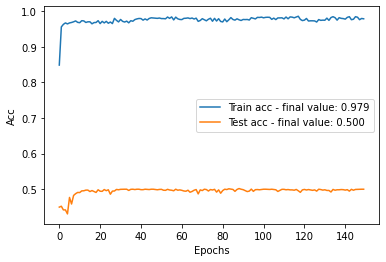

In [ ]:
acc = mdd_10.history.history["acc"]; val_acc = mdd_10.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


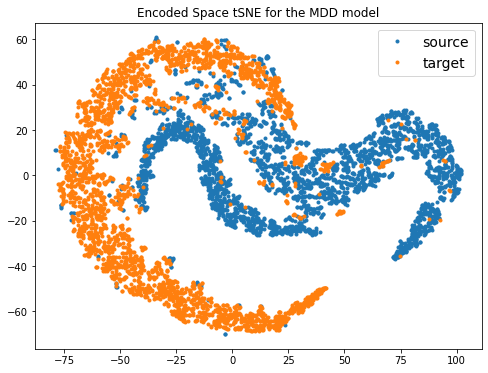

In [ ]:
LC25000_train_data_enc = mdd_10.transform(LC25000_train_data_au_ex)
TCGA_train_data_enc = mdd_10.transform(TCGA_cyclegan_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_au_ex), 0], X_tsne[:len(LC25000_train_data_au_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_au_ex):, 0], X_tsne[len(LC25000_train_data_au_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the MDD model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(mdd_10.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,disc_loss,val_loss,val_acc
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,0.073553,0.975523,3.529841,14.523200,0.495129
std,0.034664,0.011760,1.047679,4.134258,0.010853
min,0.043655,0.848750,1.519543,1.403445,0.430625
25%,0.058840,0.972812,2.788245,13.173741,0.495625
50%,0.069231,0.976875,3.386986,15.503793,0.498281
75%,0.081581,0.980313,4.032218,16.951754,0.499375
max,0.451885,0.985937,7.745893,24.131603,0.501875


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_256/MDD_Resnet_256_RMS_0.5e-5_g3_AU_cyclegan.csv")

In [ ]:
import gc
gc.collect()

4091